### Использованные библиотеки

In [ ]:
!pip install -q -r requirements.txt

### Часть 1

Здесь мы научимся генерировать положительные отзывы, посмотрим, какие есть нюансы, и проанализируем, как работает SFT, модель с hinge-лоссом и модель с sigmoid-лоссом

In [8]:
from scipy.stats import entropy
import numpy as np

import torch
from torch import nn

import random
import os

from tqdm.auto import tqdm, trange

from datasets import Dataset, load_dataset
from transformers import TrainingArguments
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from trl import DPOTrainer

from typing import Optional, Dict
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
def token_entropy(generations, tokenizer):
    stats = defaultdict(int)
    num_tokens = 0
    for example in generations:
        tokens = tokenizer.encode(example)
        for t in tokens:
            if t == tokenizer.pad_token_id:
                continue
            stats[t] += 1
            num_tokens += 1
    for k in stats.keys():
        stats[k] /= num_tokens
    return entropy(list(stats.values()))

Вроде бы такая функция уже неплохо оценивает разнообразие, ведь это буквально доля уникальных токенов, даже сложно придумать, что могло бы быть лучше. Можно было бы попробовать подсчитать долю использованных слов из всего словаря или долю разных токенов по предложениям, но непонятно, чем это должно быть лучше. К тому же именно такая мера была использована в статье

#### 1.1 Генерация позитивных отзывов
----------------

Сначала нужно взять sft-модель и разобраться, как она работает. Для этого достаточно ознакомиться с интерфейсом с huggingface

In [4]:
model_name = "lvwerra/gpt2-imdb"

tokenizer = GPT2Tokenizer.from_pretrained(
    model_name, padding_side='left', add_prefix_space=True
)
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained(
    model_name, pad_token_id=tokenizer.pad_token_id,
).to(device)

Ниже простенькая функция генерации вместо той, что есть по дефолту. Параметры я подобрал такие, чтобы получалось что-то более-менее осмысленное, но не слишком длинное, а то долго обучаться. Сразу же добавил дефолтные опции для генерации положительных отзывов, подобрал чисто экспериментально. В генерации встречаются мусорные токены от html разметки, ну да что поделать. Я вычистил всё, что попалось мне на глаза

In [5]:
from token_data import good_tokens, bad_tokens, omit_tokens

def get_tokens_as_tuple(word):
    return tuple(tokenizer([word], add_special_tokens=False).input_ids[0])

def generate_from_input(
    inp: Optional[str] = "",
    debug: Optional[bool] = False,
    naive_guidance: Optional[str] = None,
    sequence_bias: Optional[Dict[str, float]] = None,
    **generation_config
):
    guidance_dict = {
        "positive": f"This movie is great. {inp}",
        "negative": f"This movie is bad. {inp}",
        None: "..." if inp == "" else inp
    }
    inp = guidance_dict[naive_guidance].rstrip()
    input_ids = tokenizer.encode(
        inp, return_tensors='pt',
        add_special_tokens=True,
        add_prefix_space=False,
        padding=True
    ).to(device)
    beam_output = model.generate(
        input_ids, do_sample=True,
        sequence_bias=sequence_bias,
        **generation_config
    ).to(device)
    output = tokenizer.decode(
        beam_output[0], skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )
    if debug:
        print(beam_output[0])
    return ".".join(output.split(".")[:-1]) + "."

bad_words_ids = [ids[1:] for ids in tokenizer(omit_tokens, add_special_tokens=False).input_ids]
default_generation_config = dict(
    top_k=50,
    num_beams=5,
    max_length=200,
    early_stopping=False,
    no_repeat_ngram_size=2,
    renormalize_logits=True,
    min_new_tokens=5,
    repetition_penalty=1.5,
    temperature=1.5,
    bad_words_ids=bad_words_ids,
)

factor = 0.33 # начальный bias слишком сильный
bias_tokens = dict(good_tokens, **bad_tokens)
pos_bias = {get_tokens_as_tuple(k): factor*v for k, v in bias_tokens.items()}
neg_bias = {k: -v for k, v in pos_bias.items()}

In [5]:
torch.nn.functional.one_hot(torch.tensor(2),10)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

Кажется, это самый простой способ сделать отзыв более положительным - а именно вставить ключевые слова в промпт, у меня это параметр `naive_guidance`. Очень прогрессивно, но работает не то, чтобы слишком хорошо. Что ещё можно сделать:

1. **Beam Search**. У меня была мысль с более хитрым отбором кандидатов во время бим сёрча - можно оставлять такие опции, которые не только более вероятны, но и имеют положительную тональность. Как если бы была задача максимизировать и вероятность предложения, и тональность, как при мультилейбл Это можно сделать даже при помощи той же gpt2, если взять другую архитектуру, но пришлось бы переделывать функцию генерации, это во-первых не очень очевидно, во-вторых будет не совсем эффективно вроде как, потокенная генерация дело долгое. В общем, показалось, что это просто слишком сложно для самого начала задания, ответ наверное должен быть проще. Если бы я мог решить эту проблему на этапе бим сёрча, всё задание ниже не имело бы смысла. Ну и код в transformers не такой очевидный, чтобы можно было его пропатчить, так что я забил

2. **The more the better**. Была мысль с банальной генерацией как можно большего числа примеров. Среди них осталось бы выделить позитивные примеры и радоваться жизни, но это не модификация генерации. К тому же я и так буду генерировать сразу кучу, почему бы и нет

3. **(Supervised) Fine-Tuning**. Файн-тюн это тоже опция, конечно, но это фактически попытка решить нашу задачу, тоже не то. К тому же мне придётся откуда-то взять позитивные отзывы, это можно, но это чит. Понятно, что этот же IMDB датасет можно легко стащить, он есть в открытом доступе, оттуда взять положительных примеров, но это слишком легко, и это не адаптация модели. Я реализовал эту вещь, но не использовал

4. **Prompt Engineering**. Модифицировать промпт это тоже не совсем понятная вещь, потому что прописать можно много всего разного. Я остановился на 'Good Review', он вполне себе даёт результаты, как будет видно ниже. Понятно, что есть другие ключевые слова, их я тоже попробовал вставить через байас, чтобы не принуждать модель, но побуждать генерировать то, что я хочу. Синонимы я достал через [сайтик](https://www.thesaurus.com/browse/good), потому что nltk даёт либо слишком мало, либо много. Это не очень много времени занимает. Байас дал соответственно силе синонимов, но это тоже спорно, ведь никакого порядка на самом деле нет, это очевидно. Но всё равно это вещь очень тонкая, потому что чем больше байас, тем меньше дайвёрсити, если смотреть не только на скор классификатора, но и на сами тексты. Можно покрутить, я всё для этого оставил. В общем, такую опцию я тожн реализовал, но делал всё же тоже без неё

Проверять качество я буду в первую очередь глазами. Даже в статье среди примеров оказывается, что при казалось бы неплохих показателях качества сами тексты состоят из одного слова например. Очевидно, такое нам не слишком подходит. Проверять я буду на пустом инпуте, чтобы проверить, что модель подстроилась даже без гайданса

Ниже парочка примеров генерации

In [70]:
generate_from_input()

'... - I must say, this movie really surprised me.'

In [17]:
generate_from_input(**default_generation_config)

"... and I don't know what to say about it. If you are a fan of the series, you will like this one."

In [90]:
generate_from_input(naive_guidance="positive", **default_generation_config)

"This movie is great. If you are looking for a good action/thriller, or if you just want to know how to make a horror movie, this is the movie for you. There is a lot going on in this movie that I didn't know about before. This movie takes itself seriously. Don't be fooled into thinking that it will be your cup of tea. You will not be disappointed. It is definitely one of the best movies I have ever seen. I highly recommend it to anyone who wants to see an action movie."

In [91]:
generate_from_input(
    naive_guidance="positive",
    sequence_bias=pos_bias,
    **default_generation_config
)

"This movie is great. The cast is excellent and the direction is superb. This movie could have been great in it's own right, but it didn't. I think this movie will be great for those who like to watch great movies with great actors and good directing. If you're looking for a great movie, this isn't it. However, if you just want to see great films with good acting and great directing, then this is the movie for you. And if your looking to rent a good movie with excellent directing and excellent acting, go ahead and give this one a shot."

---------
Дальше нужна модель, которая будет эти отзывы оценивать, та же, что требуется по заданию

In [6]:
model_name = "lvwerra/distilbert-imdb"

clf_tokenizer = DistilBertTokenizer.from_pretrained(model_name)
clf = DistilBertForSequenceClassification.from_pretrained(model_name).to(device)
sigmoid = nn.Sigmoid()

Сразу же добавлю функцию классификации и посчитаю средний скор по каждой из стратегий генерации - рандомной, позитивной, негативной. Заодно посмотрим на влияние байаса

In [7]:
def classify(inp, as_proba=True):
    inputs = clf_tokenizer(inp, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = clf(**inputs).logits
    if as_proba:
        logits = sigmoid(logits)
    return logits[:, 1].cpu().numpy()

multiclassify = np.vectorize(classify)

In [96]:
n_samples = 30
samples = np.empty((n_samples, 3), dtype=object)
for i in trange(n_samples):
    for j, guidance in enumerate([None, "negative", "positive"]):
        samples[i, j] = generate_from_input(
            naive_guidance=guidance, **default_generation_config
        )

scores = multiclassify(samples)
print(*samples[:3, 2], sep="\n")
dict(zip(["random", "negative", "positive"], scores.mean(0)))

  0%|          | 0/30 [00:00<?, ?it/s]

This movie is great. It's a must see if you are looking for a good horror movie or just want to see the best of the genre. You will love this movie. A must-see for any horror fan. If you don't like horror movies, don´t waste your time on this one.
This movie is great. It has a great script and a good cast. This movie should have been made in the 90's. The only bad thing about this movie was that it didn't have anything to do with the "movie" at all. There was nothing to talk about other than the fact that no one cared about the movie. I felt sorry for these people who lost their jobs and had to go to college, but I feel sorry more for the people involved in this film. Don't waste your money on this crap. If you want to see a better version of this kind of movie, don't rent it.
This movie is great. I love it so much that I am renting it on DVD. It is the only movie I have ever seen in my whole life. If you are looking for a good horror movie, check this one out. Don't miss it.


{'random': 0.44256103, 'negative': 0.0569645, 'positive': 0.8428106}

In [97]:
n_samples = 30
samples = np.empty((n_samples, 3), dtype=object)
for i in trange(n_samples):
    for j, (guidance, bias) in enumerate(
        zip([None, "negative", "positive"], [None, neg_bias, pos_bias])
    ):
        samples[i, j] = generate_from_input(
            naive_guidance=guidance, sequence_bias=bias, **default_generation_config
        )

scores = multiclassify(samples)
print(*samples[:3, 2], sep="\n")
dict(zip(["random", "negative", "positive"], scores.mean(0)))

  0%|          | 0/30 [00:00<?, ?it/s]

This movie is great. I love the good acting and the wonderful soundtrack. The sound quality is good too. This is a good movie to watch over and over again. If you like good horror movies with good music, great cinematography and good special effects, then check this one out. Even if you don't like this movie, stay away from it. Don't rent this film unless you are a fan of great horror films.
This movie is great. I don't think I've ever seen a movie like this before. The acting is good, the story is interesting, and the music is wonderful. It's good to see the good old days of the 70's and 80's. Don't get me wrong, it's great to watch great movies. However, if you're a fan of good movies, you'll love this movie. You won't regret it. If you are looking for a good movie with good music, good acting, great songs, excellent cinematography, or good special effects, this is the movie for you.
This movie is great. It has great chemistry with all the great actors in this movie. I love the fact 

{'random': 0.56497085, 'negative': 0.050454352, 'positive': 0.88085556}

Как можно заметить, если добавить байас, то позитивность растёт сильно, но это бьёт по дайверсити, как мы неоднократно похже увидим - там одни и те же слова. Позже я приду к выводу, что нужны и как можно более разные тексты, и как можно более положительные, так что можно это обеспечить сразу и выбрать всё же вариант без байаса, но отобрать из него всё самое положительное. Нагенерирую побольше образцов, хотя для обучения понадобится не так много. В целом всё вроде работает, это успех. Разве что сами отзывы порой бредовые из-за температуры

In [11]:
seed_everything(69)

n_samples = 3000
samples = np.empty(n_samples, dtype=object)
for i in trange(n_samples):
    sample = generate_from_input(naive_guidance="positive", **default_generation_config)
    samples[i] = sample.replace("This movie is great. ", "")

  0%|          | 0/3000 [00:00<?, ?it/s]

------------------------
Дальше нужно каждый из них оценить, благо это не очень долго. Средний реворд действительно больше 0, всё в целом нормально, разнообразие тоже посчитано внизу, но кажется, что разницы между сентиментом и ревордом нет, так что who cares

In [13]:
reward = np.vectorize(lambda x: classify(x, False))(samples)
diversity = token_entropy(samples, tokenizer)
f"Mean reward: {reward.mean()}, Max reward: {reward.max()}, Diversity: {diversity}"

'Mean reward: 1.5335084199905396, Max reward: 2.936217784881592, Diversity: 5.668224415824242'

Все отзывы и реворды я на всякий случай сохранил, ведь считаются они долго

In [4]:
# np.savez("src/samples", samples)
# np.savez("src/rewards", reward)

samples = np.load("src/samples.npz", allow_pickle=True)["arr_0"]
reward = np.load("src/rewards.npz")["arr_0"]

Я возьму за хорошие пары все те, у которых реворд больше 2.5, кажется, что они достаточно положительные. Если взять больший трешхолд, то в rejected могут оказаться положительные отзывы, но недостаточно подробные, например. Проблема может быть в том, что некоторые тексты окажутся уж слишком похожи и нашей модели ничего нового не сообщат. На самом деле это вполне успешно фиксится убиранием байаса, как я сделал выше, но фильтр по дайвёрсити тоже можно добавить, я сделал ниже. Но он работает очень долго, лучше решить проблему сразу на этапе генерации. Отрицательные пары это те, реворд которых меньше 1.75. Ниже примерчики

In [13]:
winner = reward >= 2.5
loser = reward < 1.75

winner.sum(), loser.sum()

(1163, 1089)

In [14]:
np.random.choice(samples[winner], 1), np.random.choice(samples[loser], 1), 

(array(["I loved it so much that I rented it on DVD and watched it several times over the course of a couple of weeks. It's a fun film to watch, and I'm not going to tell you how many times I watched this movie. But if you're looking for a great romantic comedy, check it out."],
       dtype=object),
 array(["It's a great story, but at the same time it's one of the most boring movies I've ever seen. I don't know about you, or maybe you haven't seen the movie yet, and I'm sure you won't. But if you do see this movie, be prepared for an hour and a half that will make you want to kill yourself. Don't waste your time with this bad movie."],
       dtype=object))

In [6]:
# # pdist from scipy is not as convenient
# # да, это довольно долго

# dist_set = winner_samples
# N = len(dist_set)
# pdist = np.empty((N, N), dtype=float)

# for i in trange(N):
#     for j in range(i+1, N):
#         pdist[i, j] = token_entropy([dist_set[i], dist_set[j]], tokenizer)
#         pdist[j, i] = pdist[i, j]

Останется только собрать из них датасет и можно будет приступать к обучению. Всё это уже завёрнуто в пайплайн, но здесь тоже можно полюбоваться

In [13]:
def generate_dataset(n_samples):
    
    dpo_dataset = defaultdict(list)

    winner_sample = np.random.choice(winner_samples, size=n_samples)
    loser_sample = np.random.choice(loser_samples, size=n_samples)
    prompts = ["This movie is great. "]*n_samples

    dpo_dataset["prompt"] = prompts
    dpo_dataset["chosen"] = winner_sample  
    dpo_dataset["rejected"] = loser_sample

    dpo_dataset = Dataset.from_dict(dpo_dataset)
    dpo_dataset = dpo_dataset.map(batched=True)
    
    return dpo_dataset

def get_imdb_prompts(n_samples):
    dataset = load_dataset("imdb")
    imdb_prompts = [row["text"].split(".")[0] for row in dataset["train"] if row["label"] == 1]
    return np.random.choice(imdb_prompts, n_samples)

#### 1.2 Сравнение лоссов
------------
Всю логику обучения я оформил в отдельном классе, потому что вызывать её придётся очень часто, можно с этим ознакомиться там. Вкратце: загружаем датасет, копируем модельки, запускаем `DPOTrainer` с нужными параметрами, обучаем, сохраняем метрики. Фактически делается всё то же самое, что я только что описал в ячейках выше. Запусков несколько, но сид между ними общий, чтобы можно было адекватно сравнивать

In [14]:
import pandas as pd
import numpy as np
from pipeline import Pipeline
from tqdm.auto import trange
from glob import glob

Сперва всё равно нужен обычный запуск, чтобы сравнивать, насколько улучшилось качество

In [ ]:
pipe = Pipeline()
pipe.evaluate(f"default", n_samples=100)

Дальше уже можно делать собственно задание

In [ ]:
for i in trange(5):
    pipe = Pipeline()
    pipe.train(loss_type="hinge", n_samples=1000, random_state=i)
    pipe.evaluate(f"hinge_{i}", n_samples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'eval_loss': 1.0, 'eval_runtime': 109.4007, 'eval_samples_per_second': 1.828, 'eval_steps_per_second': 1.828, 'eval_rewards/chosen': 0.0, 'eval_rewards/rejected': 0.0, 'eval_rewards/accuracies': 0.0, 'eval_rewards/margins': 0.0, 'eval_logps/rejected': -1280.8216552734375, 'eval_logps/chosen': -322.8234558105469, 'eval_logits/rejected': -52.44643020629883, 'eval_logits/chosen': -51.158809661865234, 'epoch': 1.0}
{'eval_loss': 1.0, 'eval_runtime': 107.1882, 'eval_samples_per_second': 1.866, 'eval_steps_per_second': 1.866, 'eval_rewards/chosen': 0.0, 'eval_rewards/rejected': 0.0, 'eval_rewards/accuracies': 0.0, 'eval_rewards/margins': 0.0, 'eval_logps/rejected': -6991.60205078125, 'eval_logps/chosen': -2182.47314453125, 'eval_logits/rejected': -33.1998176574707, 'eval_logits/chosen': -36.7837028503418, 'epoch': 2.0}


Checkpoint destination directory experiment_logs/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 1.0, 'learning_rate': 2.702702702702703e-06, 'rewards/chosen': 0.0, 'rewards/rejected': 0.0, 'rewards/accuracies': 0.0, 'rewards/margins': 0.0, 'logps/rejected': -3741.187744140625, 'logps/chosen': -1396.5260009765625, 'logits/rejected': -41.03522872924805, 'logits/chosen': -41.643829345703125, 'epoch': 2.5}
{'eval_loss': 1.0, 'eval_runtime': 98.6584, 'eval_samples_per_second': 2.027, 'eval_steps_per_second': 2.027, 'eval_rewards/chosen': 0.0, 'eval_rewards/rejected': 0.0, 'eval_rewards/accuracies': 0.0, 'eval_rewards/margins': 0.0, 'eval_logps/rejected': -8539.861328125, 'eval_logps/chosen': -2721.215087890625, 'eval_logits/rejected': -33.41294860839844, 'eval_logits/chosen': -36.64543533325195, 'epoch': 3.0}


Если взять какой-нибудь нейтральный промпт, то результаты будут очень даже ничего

In [5]:
# hinge

for _ in range(3):
    print(pipe.generate_from_input("This movie"))

This movie is a must-see for all fans of science fiction, sci-fi and fantasy.
This movie is one of my all-time favorites.
This movie is well worth every minute of your time. I highly recommend this movie to all of you.


Ну и из того, что модель нагенерировала во время оценки качества, тоже неплохо, только мусорные теги немного уродуют тексты

In [41]:
pd.read_csv("experiments/hinge_0.csv").sample(3)["sample"].values

array(['... the music is outstanding, and the acting is superb. I highly recommend this film to anyone interested in the world of music. 10 out of 10.',
       "... and it's worth a watch.<BR><Br />8/10.",
       '... of this film. I highly recommend this movie to anyone who loves suspense and thriller. 10 out of 10.'],
      dtype=object)

Осталось посмотреть на sigmoid лосс

In [ ]:
for i in trange(10):
    pipe = Pipeline()
    pipe.train(loss_type="sigmoid", n_samples=200, random_state=i)
    pipe.evaluate(f"sigmoid_{i}", n_samples=100)

In [4]:
# sigmoid

for _ in range(3):
    print(pipe.generate_from_input("This movie"))

This movie great this movie. It is great. The acting is good, the story is well told, and the special effects are very good. This is one of the best movies I have seen in a long time.
This movie great this movie. It is great. The acting is good, the story is well told, and the characters are well developed. This is one of the best movies I have seen in a long time.
This movie great this movie. It is great. The acting is good, the story is well told, and the special effects are very good. This is one of the best movies I have seen in a long time.


In [19]:
all_dfs = [df for loss in ["sigmoid", "hinge", "default"] for df in glob(f"experiments/{loss}*.csv")]
summary = pd.concat([pd.read_csv(df) for df in all_dfs])
summary["experiment"] = summary.experiment.map(lambda x: x.split("_")[0])

In [21]:
mean_summary = (
    summary \
    .groupby("experiment") \
    .mean("reward") \
    .sort_values("reward") \
    .reset_index()
)
mean_summary.loc[mean_summary.shape[0]] = ["best", 2.935, 4.732]
mean_summary.T

,0,1,2,3
experiment,default,hinge,sigmoid,best
reward,-0.068486,2.5702,2.579585,2.935
diversity,5.825884,4.65901,4.661635,4.732


Как видно, между лоссами нет особой разницы, как обычно её нет при обучении свм и логрега. В общем и целом можно заметить, что средний реворд действительно вырос и очень даже неплохо, но при этом сильно пострадало разнообразие текстов. К сожалению, это суровая реальность - если генерировать только позитив, негатива, например, не будет. Можно заметить, что лоссы почти одинаковые, это может быть не очень хорошо, но быть может и обучение было проведено тоже не идеально. За `best` я взял распределение из виннеров, которое получилось после отбора кандидатов, в идеале хотели бы что-то такое, что я отфильтровал из датасета в части 1.1

Последнее, что можно сделать, это в целом оценить распределение ревордов и дайвёрсити разных лоссов, может быть хотя бы в этом они отличаются. Тогда лучше взять то, что будет постабильнее. Тут как раз и сравним с исходной sft моделью. Графики издалека выглядят не очень, но всегда можно приблизить, если что

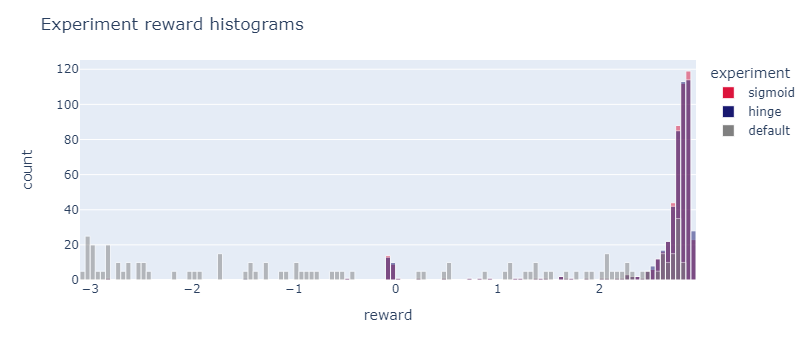

In [24]:
import plotly.express as px

# we'll have to duplcate sft default examples, otherwise
# they are to few to be seen on the plot
sub_df = summary[summary.experiment == "default"]
sub_df = pd.concat([summary, sub_df.loc[sub_df.index.repeat(4)]])
fig = px.histogram(
    sub_df, x="reward", color="experiment",
    nbins=150, opacity=0.5, barmode="overlay",
    color_discrete_sequence=["crimson", "midnightblue", "grey"]
)
fig.update_layout(title="Experiment reward histograms")
fig.update_traces(marker_line_width=1 ,marker_line_color="white")
fig.show()

В общем, как будто бы нет почти никакой разницы. Единственное, что можно отметить - наличие выбросов, когда сентимент всё же недостаточно позитивный. Это можно списать на недообучение. Так или иначе, это промпт без гайданса, и он получается значительно более положительный, чем изначально. Так что всё работает, лосс по всей видимости не важен. А обычная модель генерирует всё подряд, оно и понятно, распределение равномерное